In [6]:
import numpy as np 
import matplotlib.pyplot as plt  
from scipy import sparse
import os

## Reading sample data

In [4]:
input_folder = "input-data"
times = np.load(os.path.join(input_folder, "times.npy"))
indices = np.load(os.path.join(input_folder, "indices.npy"))
times_pattern = np.load(os.path.join(input_folder, "times_pattern.npy"))
indices_pattern = np.load(os.path.join(input_folder, "indices_pattern.npy"))
position_copypaste = np.load(os.path.join(input_folder, "position_copypaste.npy"))

In [7]:
sparse_spike_train = sparse.load_npz(os.path.join(input_folder, "sparse_spike_train.npz"))
spike_train = sparse_spike_train.toarray()
pattern_times = list(np.load(os.path.join(input_folder, "pattern_times.npy")))

## Creating Neurons, Synapses, Learning Rule, Network

In [19]:
from typing import Iterable, Optional
import numpy

some notes for my own development:
- for now all the initialization parameters are None, you can change to some default values in the future.

- Pay attention to register_buffer for some of the parameters in the model. The ones which do not need to be trained but are needed to save in `state_dict`. When moving the code to Pytorch maybe!

- 

In [108]:
class Synapse():
    def __init__(self, w: numpy.array):
        self.w = w
        self.vfunc = np.vectorize(self.get_tmp_w_)
        ### TODO: Somewhere in the code, the same place I calculate
        ### the correct current spikes_t I should also calculate tmp_w
        ### using the code below!
        tmp_w = vfunc(spikes_i)
        tmp_w

    def get_tmp_w_(self, w_j):
            return self.w[w_j]


In [136]:
from typing import Any


class SRM():
    def __init__(
            self, 
            N: int = None,
            threshold: float = None,
            reset: float = None,
            refractory: float = None, # refractory is a float time [second]
            tau_m: float = None,
            tau_s: float = None,
            K1: float = None,
            K2: float = None,
            input_window: float = None, # Maximum time [second] to ignore inputs before it by kernels 
            train_mode: bool = True
        ) -> None:
        """
        """
        assert N is not None, "Number of neurons must be provided."

        self.N = N
        self.threshold = threshold
        self.reset = reset
        self.refractory = refractory
        self.tau_m = tau_m
        self.tau_s = tau_s
        self.K1 = K1
        self.K2 = K2
        self.input_window = input_window
        self.train_mode = train_mode
        ## TODO: Do I need to tell the model about dt? dt should be given by user in net = Networ()
        self.dt = None
        ## TODO: I think we need to keep track of current time (t).
        ## TODO: Updating self.t will occur inside the net = Network? 
        self.t = None
        self.last_spike_time = - np.inf

        self.v = None
        self.potential_rec = []
    
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        self.forward()
            
    def forward(self, spikes_t: numpy.array, tmp_w: numpy.array, ):
        """
        spikes_t here is a correct window of spikes_t.
        """
        if len(spikes_t) != 0:

            s = self.t - spikes_t
            eps = self.eps_kernel(s)
            # print(f"eps = {eps}")
            # print(f"tmp_w = {tmp_w}")
            eps *= tmp_w
            eps = sum(eps)
            # print(eps)
            s = self.t + self.dt - self.last_spike_time
            eta = self.eta_kernel(s)
            # print(eta)
            potential = eta + eps
            # print(potential)
            self.potential_rec.append(potential)
            # return potential


    def reset_neuron(self,):
        ### what should be reseted exactly?
        self.t = 0
        self.v = self.reset
        self.last_spike_time = - np.inf
    
    
    ## TODO: use compute_k() when adding the layer into the Network()
    def compute_K(self):
        """
        K is chosen such that the maximum value of epsilon kernel will be 1, based on the tau_m and tau_s.
        """
        s_max = (self.tau_m * self.tau_s) / (self.tau_s - self.tau_m) * np.log(self.tau_s / self.tau_m)
        max_val = (np.exp(-s_max/self.tau_m) - np.exp(-s_max/self.tau_s))
        self.K = 1 / max_val
    
    def eps_kernel(self, s: numpy.array):
        """"
        s = t - t_j 
        time difference between thre current time and spike time of presynaptic neuron (t_j)
        """
        return self.K * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))

    def eta_kernel(self, s: numpy.array):
        """
        s = t - t_i
        """
        positive_pulse = self.K1 * np.exp(-s/self.tau_m)
        negative_spike_afterpotential = self.K2 * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
        return self.threshold * (positive_pulse - negative_spike_afterpotential)


    


In [137]:
assert (False and True), "if assert gets Flase then we get an error message!" 

AssertionError: if assert gets Flase then we get an error message!

In [138]:
dt = 0.001
spikes_t = np.array([2, 23, 44, 45, 48, 61]) * dt
spikes_i = np.array([0, 0,  0,  1,  1,  1])
weight_example = np.array([1,1], dtype=float).reshape(-1,1)
tmp_w = np.array([1, 1, 1, 1, 1, 1])

# spikes_t = np.array([10, 12, 14, 14,]) * dt
# spikes_i = np.array([0,  1,  0,  1,])
# w = np.array([1,5])
model = SRM(N=3,
            threshold=2.9,
            reset= 0,
            refractory=0.001, # refractory is a float time [second]
            tau_m=0.010,
            tau_s=0.0025,
            K1=2,
            K2=4,
            input_window= 7 * 0.010, # Maximum time [second] to ignore inputs before it by kernels 
            train_mode= True )

In [139]:
model.t = 0 * dt
model.compute_K()
model.last_spike_time = - np.inf
model.dt = dt 
for it in range(75):
    model.t = it * dt
    idx = np.searchsorted(spikes_t, it*dt, side='right')
    model.forward(spikes_t[:idx], tmp_w[:idx])

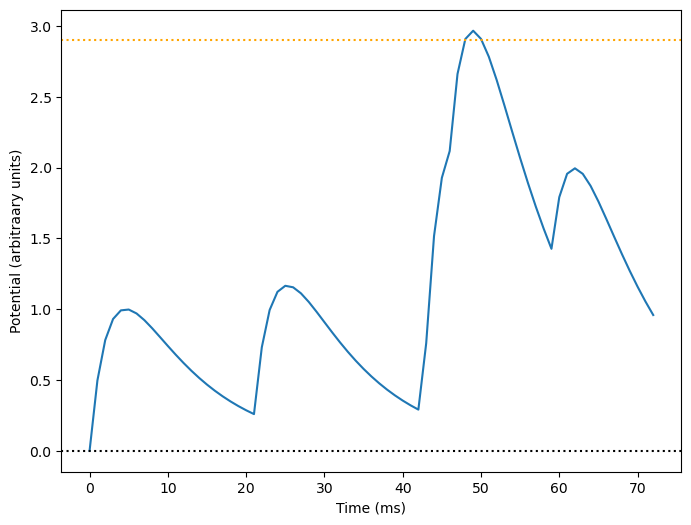

In [141]:
def plot_membrane_potential(potential_rec, threshold):
        plt.figure(figsize=(8,6))
        plt.plot(np.arange(0,len(potential_rec),1), potential_rec)
        # spikes = np.where(spike_train ==1)[1]
        # for spk in spikes:
            # plt.axvline(spk, linestyle='-.', color='gray')
        plt.axhline(threshold, linestyle='dotted', color='orange')
        plt.axhline(0, linestyle='dotted', color='k')
        plt.xlabel('Time (ms)')
        plt.ylabel('Potential (arbitraary units)')
        plt.show()

plot_membrane_potential(model.potential_rec, 2.9)

In [107]:
def tmp_w_creator(w_j):
    return w[w_j]

vfunc = np.vectorize(tmp_w_creator)
tmp_w = vfunc(spikes_i)
tmp_w


array([1, 5, 1, 5])

In [86]:
dt = 0.001
for it in range(int(spikes_t[-1])+2):
    print(f"at iteration {it}, calculating epsilon for time: {it+1}ms")
    print(spikes_t)
    idx = np.searchsorted(spikes_t, it, side='right')
    print(spikes_t[:idx])
    print(f"idx = {idx}")
    print()


at iteration 0, calculating epsilon for time: 1ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0]
idx = 1

at iteration 1, calculating epsilon for time: 2ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0]
idx = 1

at iteration 2, calculating epsilon for time: 3ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2]
idx = 2

at iteration 3, calculating epsilon for time: 4ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2]
idx = 2

at iteration 4, calculating epsilon for time: 5ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2 4]
idx = 3

at iteration 5, calculating epsilon for time: 6ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2 4 5]
idx = 4

at iteration 6, calculating epsilon for time: 7ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2 4 5 6]
idx = 5

at iteration 7, calculating epsilon for time: 8ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2 4 5 6 7]
idx = 6

at iteration 8, calculating epsilon for time: 9ms
[ 0  2  4  5  6  7 10 12 14 14 16 17]
[0 2 4 5 6 7]
idx = 6

at iteration 9, calculating epsilon for time: 10m